In [115]:
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from matplotlib import pyplot as plt
%matplotlib inline
import re
import os,sys, shutil
import time
from datetime import date
try:
    import cPickle as pickle
except:
    import pickle
import pprint
from collections import deque
from shutil import copyfile
import random
import glob
# Import the required modules
import cv2, os
import numpy as np
from PIL import Image
from sklearn.cross_validation import KFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Logistic Regression
from sklearn import datasets
from sklearn import metrics
import pandas as pd
import math
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [2]:
pkl_fl = open("linkedin_profiles.pickle","rb")
my_original_list=pickle.load(pkl_fl) # errors out here
pkl_fl.close()

In [3]:
directory = "Male"
    
if os.path.exists(directory):
    shutil.rmtree(directory)
    os.makedirs(directory)     
else:
    os.makedirs(directory) 

directory1 = "Female"

if os.path.exists(directory1):
    shutil.rmtree(directory1)
    os.makedirs(directory1)     
else:
    os.makedirs(directory1)     

directory2 = "Label_Images_Gender"

if os.path.exists(directory2):
    shutil.rmtree(directory2)
    os.makedirs(directory2)     
else:
    os.makedirs(directory2)     
    
fileList = glob.glob("./Images/*.*")

for id,fp in enumerate(fileList):
    filename, file_extension = os.path.splitext(fp)
    uid = filename.split('/')[-1]
    #print fp
    for prof in my_original_list:
        if prof['User_ID'] == uid:
            new_file_extension = prof['Gender']
            new_file_extension = new_file_extension.title()
            if new_file_extension != 'Unknown':
                copyfile(filename+".jpg", './Label_Images_Gender/'+ uid + '.' + str(id) + "."+new_file_extension +'.jpg')
                copyfile(filename+".jpg", new_file_extension +'/' + uid + ".jpg")

In [3]:
# For face detection we will use the Haar Cascade provided by OpenCV.
cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)

# For face recognition we will the the LBPH Face Recognizer 
recognizer = cv2.createLBPHFaceRecognizer()

In [4]:
def get_images_and_labels(path):
    # Append all the absolute image paths in a list image_paths
    
    image_paths = [os.path.join(path, f) for f in os.listdir(path)]
    # images will contains face images
    images = []
    # labels will contains the label that is assigned to the image
    labels = []
    #gender will contains 1 or 0 indecating male or female
    gender =[]
    
    for image_path in image_paths:
        # Read the image and convert to grayscale
        try:
            image_pil = Image.open(image_path).convert('L')
            # Convert the image format into numpy array
            image = np.array(image_pil, 'uint8')
            # Get the label of the image
        except:
            pass
        
        nbr = int(os.path.split(image_path)[1].split(".")[1])
        gender_current = os.path.split(image_path)[1].split(".")[2]
        print nbr
        
        # Detect the face in the image
        faces = faceCascade.detectMultiScale(image)
        # If face is detected, append the face to images and the label to labels
        try:
            for (x, y, w, h) in faces:

                ref_image = image[y: y + h, x: x + w]
                resized = cv2.resize(ref_image, (100, 100), interpolation = cv2.INTER_AREA)
                #edge_images = cv2.Canny(resized,100,200)
                
                images.append(np.array(resized))   #resized.reshape(1,10000)
                labels.append(nbr)

                if gender_current == 'Male':
                    gender.append(1)
                else:
                    gender.append(0)
                
                #face_file_name = "faces/face_" + str(y) + ".jpg"
                #cv2.imwrite(face_file_name, sub_face)
                
                cv2.imshow("Adding faces to traning set...", resized)
                cv2.waitKey(1)
        except:
            pass
    # return the images list and labels list
    print "lables"
    print labels
    print "gender_current"
    print gender
    
    return images, labels, gender

In [5]:
images, labels, gender = get_images_and_labels('Label_Images_Gender')

cv2.destroyAllWindows()

1870
491
2508
3052
1700
2382
132
783
1643
209
2392
442
1609
2895
406
2689
2754
89
299
1382
1096
1824
1208
1689
980
2924
2015
321
2799
1213
2802
2109
2553
2635
2175
2275
42
3192
641
260
1937
1978
2587
754
1843
1592
516
2416
3232
558
1591
2524
970
1306
135
2184
859
676
737
3118
1976
229
1904
134
2817
2317
1810
3298
2927
3036
1282
2462
1350
196
659
1108
1561
371
2664
2094
704
2352
73
1140
2783
580
786
2593
855
1154
1585
2051
986
1247
2311
3047
3223
2050
2271
370
2452
2439
43
337
2764
189
1648
3264
1199
3316
1386
295
1979
226
2973
1287
1807
2201
840
3018
161
3031
1428
2979
724
3238
1159
2968
2280
455
1403
2611
3318
2562
2429
2911
914
916
91
818
2223
642
3236
757
3322
3335
1496
3141
868
3034
1196
3261
1885
928
2019
188
3030
1543
1733
2714
3199
3163
400
2733
278
2353
2338
2900
1048
109
144
930
1802
14
2018
2766
1955
1435
2087
1338
2608
190
2180
2235
56
2103
1803
79
3095
1515
1696
2486
2117
2710
732
1808
154
405
2425
1931
245
1983
2684
2248
239
2368
3211
25
1574
3325
3338
1092
468
1188
2921
1

In [ ]:
with open("tmp_gender.pickle", "rb") as f:
    images, labels, gender = pickle.load(f) 

In [ ]:
with open("tmp_gender.pickle", "wb") as f:
    pickle.dump((images,labels,gender), f)

In [6]:
#res_images = []
res_gender = []

#for img in images:
#    res_images.append(img.reshape(1,20000))    # (100*100 image size)


for gen in gender:
    res_gender.append(np.array(gen))

res_gender = np.array(res_gender)

In [7]:
res_gender.shape

(2908,)

## Basic model parameters as external flags.

In [8]:
# Basic model parameters as external flags.
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('max_steps', 2000, 'Number of steps to run trainer.')
flags.DEFINE_integer('hidden1', 1500, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 1000, 'Number of units in hidden layer 2.')
flags.DEFINE_integer('hidden3', 500, 'Number of units in hidden layer 3.')
flags.DEFINE_integer('batch_size', 100, 'Batch size.  '
                     'Must divide evenly into the dataset sizes.')
flags.DEFINE_string('train_dir', 'data', 'Directory to put the training data.')
flags.DEFINE_boolean('fake_data', False, 'If true, uses fake data '
                     'for unit testing.')


NUM_CLASSES = 2
IMAGE_SIZE = 100
#CHANNELS = 3
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

In [27]:
n_nodes = [IMAGE_PIXELS, 1500, 1000, 500, NUM_CLASSES]
n_epochs = 10

In [ ]:
# def inference(images, hidden1_units, hidden2_units):
#     # Hidden 1
#     with tf.name_scope('hidden1'):
#         weights = tf.Variable(
#             tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
#                                 stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))),
#             name='weights')
#         biases = tf.Variable(tf.zeros([hidden1_units]),
#                              name='biases')
#         hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
#     # Hidden 2
#     with tf.name_scope('hidden2'):
#         weights = tf.Variable(
#             tf.truncated_normal([hidden1_units, hidden2_units],
#                                 stddev=1.0 / math.sqrt(float(hidden1_units))),
#             name='weights')
#         biases = tf.Variable(tf.zeros([hidden2_units]),
#                              name='biases')
#         hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
#     # Linear
#     with tf.name_scope('softmax_linear'):
#         weights = tf.Variable(
#             tf.truncated_normal([hidden2_units, NUM_CLASSES],
#                                 stddev=1.0 / math.sqrt(float(hidden2_units))),
#             name='weights')
#         biases = tf.Variable(tf.zeros([NUM_CLASSES]),
#                              name='biases')
#         logits = tf.matmul(hidden2, weights) + biases
    
#     return logits

In [28]:
def neural_network_model(data):
    n_hidden_layers = 3
    # define the layers
    layers = [] 
    for i in range(n_hidden_layers + 1):
        layers.append( {'weights':tf.Variable(tf.random_normal([n_nodes[i], n_nodes[i+1]])), 
                        'biases':tf.Variable(tf.random_normal([n_nodes[i+1]]))} )
    
    # calculate the nodal values for each layer
    calcs = [data]
    for i in range(n_hidden_layers):
        calcs.append( tf.nn.relu(tf.matmul(calcs[i], layers[i]['weights']) + layers[i]['biases']) )

    #  return the last layer of nodes
    return tf.matmul(calcs[-1], layers[-1]['weights']) + layers[-1]['biases']

In [ ]:
# def cal_loss(logits, labels):
#     #labels = tf.to_int64(labels)
#     cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
#         logits, labels, name='xentropy')
#     loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
  
#     return loss

In [ ]:
# def training(loss, learning_rate):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#     global_step = tf.Variable(0, name='global_step', trainable=False)
#     train_op = optimizer.minimize(loss, global_step=global_step)
  
#     return train_op

In [11]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, 1)
  
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [12]:
def placeholder_inputs():
    images_placeholder = tf.placeholder(tf.float32, [None,IMAGE_PIXELS])
    labels_placeholder = tf.placeholder(tf.float32, [None,NUM_CLASSES])
    
    return images_placeholder, labels_placeholder


def fill_feed_dict(images_feed,labels_feed, images_pl, labels_pl):
    feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed,
    }
  
    return feed_dict

In [ ]:
# def do_eval(sess, eval_correct, images_placeholder, labels_placeholder, data_set):
#     # And run one epoch of eval.
#     true_count = 0  # Counts the number of correct predictions.
#     steps_per_epoch = 47 // FLAGS.batch_size
#     num_examples = steps_per_epoch * FLAGS.batch_size
#     for step in xrange(steps_per_epoch):
#         feed_dict = fill_feed_dict(train_images,train_labels,
#                                images_placeholder,
#                                labels_placeholder)
#         true_count += sess.run(eval_correct, feed_dict=feed_dict)
#     precision = true_count / num_examples
#     print('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' %
#         (num_examples, true_count, precision))

In [13]:
def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [103]:
def main():
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Generate placeholders for the images and labels.
        images_placeholder, labels_placeholder = placeholder_inputs()
        
        
        #test_images_placeholder, test_labels_placeholder = placeholder_inputs(2)
        # Build a Graph that computes predictions from the inference model.
        
#         logits = inference(images_placeholder,
#                                  FLAGS.hidden1,
#                                  FLAGS.hidden2)
        
        logits = neural_network_model(images_placeholder)
        
        
        cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits,labels_placeholder) )
        training_acc = []
        testing_acc = []
       
        #print cost
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())

#             for epoch in range(n_epochs):
#                 epoch_loss = 0
#                 for _ in range( int(train_images.shape[0] / FLAGS.batch_size) ):
#                     feed_dict = fill_feed_dict(train_images,train_labels,
#                                            images_placeholder,
#                                            labels_placeholder)
                    
#                     #epoch_x, epoch_y = mnist.train.next_batch(batch_size)
#                     _, c = sess.run([optimizer, cost], feed_dict = feed_dict)
#                     epoch_loss += c
#                 print 'Epoch', epoch, 'completed out of', n_epochs, 'loss:', epoch_loss

#             correct = tf.equal(tf.argmax(logits,1), tf.argmax(labels_placeholder,1))
#             #print correct
#             accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
#             print 'Accuracy:', accuracy.eval({images_placeholder: test_images, labels_placeholder: test_labels})
    
#         # Add to the Graph the Ops for loss calculation.
#         loss = cal_loss(logits, labels_placeholder)

#         # Add to the Graph the Ops that calculate and apply gradients.
#         train_op = training(loss, FLAGS.learning_rate)

#         # Add the Op to compare the logits to the labels during evaluation.
#         eval_correct = evaluation(logits, labels_placeholder)

#         # Create a saver for writing training checkpoints.
#         saver = tf.train.Saver()

#         # Create a session for running Ops on the Graph.
#         sess = tf.Session()

#         # Run the Op to initialize the variables.
#         init = tf.initialize_all_variables()
#         sess.run(init)
        
        # And then after everything is built, start the training loop.
            
            subset_size = 256
            for step in xrange(1000):
                start_time = time.time()
                total_loss = 0
                for i in range(int(train_images.shape[0] / subset_size) ):
                    
                    epoch_x = train_images[i * subset_size:][:subset_size]
                    epoch_y = train_labels[i * subset_size:][:subset_size]
                    
                    feed_dict = fill_feed_dict(epoch_x, epoch_y, images_placeholder, labels_placeholder)
                    
                    _, loss_value = sess.run([optimizer, cost],
                                           feed_dict=feed_dict)
                    
                    total_loss+=loss_value
                    
                duration = time.time() - start_time
                #if step % 10 == 0:
                    #Print status to stdout.
                correct = tf.equal(tf.argmax(logits,1), tf.argmax(labels_placeholder,1))
                #print correct
                accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
                
                print('Step %d: loss = %.2f (%.3f sec)' % (step, total_loss, duration)),
                
                current_train_acc = accuracy.eval({images_placeholder: train_images, labels_placeholder: train_labels})
                current_test_acc = accuracy.eval({images_placeholder: test_images, labels_placeholder: test_labels})
                
                training_acc.append(current_train_acc)
                testing_acc.append(current_test_acc)
                
                
                print('Training Accuracy:', current_train_acc),
                print('Testing Accuracy:', current_test_acc)
    
    return training_acc, testing_acc

In [93]:
# Get the sets of images and labels for training, validation, and

images = np.array(images)
images = images.reshape(images.shape[0],IMAGE_PIXELS)

#label = res_gender
labels = dense_to_one_hot(res_gender,2)

In [107]:
train_images = images[:-300]
train_labels = labels[:-300]
test_images = images[-300:]
test_labels = labels[-300:]

In [105]:
train_images.shape

(2808, 10000)

In [91]:
train_labels.shape

(2808, 2)

In [108]:
if __name__ == '__main__':
    train_acc, test_acc = main()

Step 0: loss = 149615210.00 (7.744 sec) ('Training Accuracy:', 0.63765335) ('Testing Accuracy:', 0.63999999)
Step 1: loss = 102048881.50 (7.492 sec) ('Training Accuracy:', 0.6917178) ('Testing Accuracy:', 0.66000003)
Step 2: loss = 79181780.00 (7.512 sec) ('Training Accuracy:', 0.70897239) ('Testing Accuracy:', 0.69)
Step 3: loss = 64834446.00 (8.049 sec) ('Training Accuracy:', 0.71434051) ('Testing Accuracy:', 0.71333331)
Step 4: loss = 55655517.25 (8.163 sec) ('Training Accuracy:', 0.73082823) ('Testing Accuracy:', 0.72666669)
Step 5: loss = 48624089.50 (8.768 sec) ('Training Accuracy:', 0.74194783) ('Testing Accuracy:', 0.72333336)
Step 6: loss = 42754566.75 (9.470 sec) ('Training Accuracy:', 0.74846625) ('Testing Accuracy:', 0.71666664)
Step 7: loss = 37611691.00 (9.248 sec) ('Training Accuracy:', 0.75115031) ('Testing Accuracy:', 0.71666664)
Step 8: loss = 34229123.25 (8.506 sec) ('Training Accuracy:', 0.75843561) ('Testing Accuracy:', 0.70333332)
Step 9: loss = 30942868.00 (8.558

In [112]:
max(train_acc)

0.99309814

In [113]:
max(test_acc)

0.81

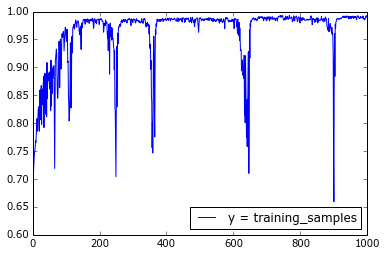

In [109]:
x = np.arange(1000)

plt.plot(x, train_acc)
#plt.plot(x, test_acc)


plt.legend(['y = training_samples', 'y = testing_samples'], loc='lower right')

plt.show()

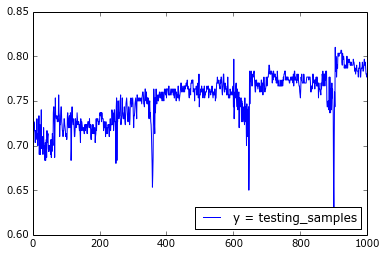

In [110]:
x = np.arange(1000)

plt.plot(x, test_acc)


plt.legend(['y = testing_samples'], loc='lower right')

plt.show()

In [116]:
accuracy_list = pd.DataFrame(
    {'Training_Acc': train_acc,
     'Testing_Acc': test_acc,
    })

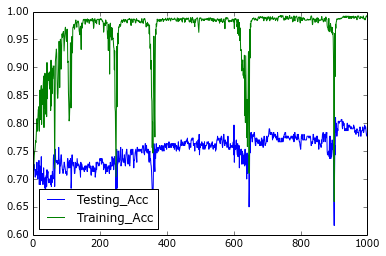

In [117]:
accuracy_list.plot()